In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import pandas as pd

import sys
current_working_dir = os.getcwd()
# get the path to directory "pe_granular_analysis"
_path = current_working_dir[:current_working_dir.find("pe_granular_analysis")+len("pe_granular_analysis")]
if _path not in sys.path:
    sys.path.append(_path)

from preprocessing.nifti_conversion import convert_dicom_to_volume_with_meta_data
from preprocessing.dataframe_formatter import dataframe_norm
from preprocessing.segmentation import segmentator_process, CustomSegmentator
from preprocessing.segmentation import segmentation2bbox_series_process  

from configs.pe.pe_final import PELabelMask

from explainer.utils.visualize_cam import visualize_suspicious_pe_region
from utils.data_visualizer import ColorImageSliceViewer3D
from utils.base import format_input_path

import gc

import torch
torch.backends.cudnn.enabled = False

/home/zhu/.conda/envs/cp310env/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Example Data settings

In [3]:
example_data_dir = os.path.join(_path, "data")
example_output_dir = os.path.join(_path, "temp")

example_pid = None
example_study_uid = "7f6fb39566ed"
example_series_uid = "b34edb1a4de7"

## Preprocessing and Segmentation

### convert dcm to nii.gz

In [4]:
conversion_msg = convert_dicom_to_volume_with_meta_data(
    input_folder=example_data_dir,
    output_folder=example_output_dir,
    pid=example_pid,
    study_uid=example_study_uid,
    series_uid=example_series_uid,
    require_meta_data=False
)

if conversion_msg is not None:
    print(f"Conversion message: {conversion_msg}")
else:
    print("Conversion successful")

/home/zhu/.conda/envs/cp310env/lib/python3.10/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: 'b34edb1a4de7'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Conversion successful


### load total-segmentator and segment lung

In [5]:
cs = CustomSegmentator(task="lung", device="cuda")

Initializing model instance... model_folder: /home/zhu/.totalsegmentator/nnunet/results/Dataset291_TotalSegmentator_part1_organs_1559subj/nnUNetTrainerNoMirroring__nnUNetPlans__3d_fullres


In [6]:
segment_msg = segmentator_process(
    segmentator_instance=cs,
    input_folder=example_output_dir,
    pid=example_pid,
    study_uid=example_study_uid,
    series_uid=example_series_uid,
)
if segment_msg is not None:
    print(f"Segmentation message: {segment_msg}")
else:
    print("Segmentation successful")

Processing /home/zhu/github/pe_granular_analysis/temp/7f6fb39566ed/b34edb1a4de7/... saving to /home/zhu/github/pe_granular_analysis/temp/7f6fb39566ed/b34edb1a4de7/segmentations
Segmentation successful


### post-process segmentation to find the BBX of lung

In [7]:
output_dict = segmentation2bbox_series_process(
        input_folder=example_output_dir,
        pid=example_pid,
        study_uid=example_study_uid,
        series_uid=example_series_uid,
        task="lung"
    )
print(output_dict)

{'PatientID': None, 'StudyInstanceUID': '7f6fb39566ed', 'SeriesInstanceUID': 'b34edb1a4de7', 'lung': [39, 126, 12, 483, 414, 167]}


### convert to dataframe for dataset

In [8]:
output_dict["image_folder"] = os.path.join(
    example_output_dir,
    format_input_path(example_pid, example_study_uid, example_series_uid)
)
df = pd.DataFrame([output_dict])

In [9]:
df

,PatientID,StudyInstanceUID,SeriesInstanceUID,lung,image_folder
0,None,7f6fb39566ed,b34edb1a4de7,"[39, 126, 12, 483, 414, 167]",/home/zhu/github/pe_granular_analysis/temp/7f6...


## PE Prediction

### load cfg

In [ ]:
cfg = PELabelMask()
cfg.ddp = False
cfg.img_size = 384 # 256 used in training
cfg.working_dir = example_output_dir
cfg.test_result_dir = example_output_dir
cfg.on_deploy = True
cfg.on_grad_cam = False
# print(cfg)

### instantiate dataset and model

In [11]:
dataset_instance = cfg.dataset_class(dataframe=df, usage="inference", config=cfg)

Inference/cam mode: No labels will be returned.


In [12]:
model_settings = cfg.get_model_setups()

model = cfg.model_class(**model_settings)

weights_path = os.path.join(
    _path,
   "models/weights/example_weight.pth"
)
model.custom_load_from_checkpoint(weights_path)
model = model.cuda()
model.eval()

/home/zhu/.conda/envs/cp310env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/zhu/.conda/envs/cp310env/lib/python3.10/site-packages/timm/layers/interpolate.py:47: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
  idx_right = torch.bucketize(x, p)
/home/zhu/github/pe_granular_analysis/models/pe/aux_classifier.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the d

=> loading checkpoint '/home/zhu/github/pe_granular_analysis/models/weights/example_weight.pth'
=> All required model keys found in checkpoint after cleaning
=> Checkpoint loaded successfully (279 parameters)


ModelWithAuxClassifier(
  (encoder_stage1): MaxxVit(
    (stem): Stem(
      (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (norm1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MbConvBlock(
            (shortcut): Downsample2d(
              (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
              (expand): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            )
            (pre_norm): BatchNormAct2d(
              64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (down): Downsample2d(
      

### inference

In [13]:
import torch
with torch.no_grad():
    _input = dataset_instance[0]
    input_images = _input["images"]
    input_images = input_images.cuda().unsqueeze(0)
    outputs = model(input_images)
    prediction = torch.sigmoid(outputs).cpu().numpy()

In [14]:
prediction

array([0.98438925], dtype=float32)

### clean up

In [15]:
del model
del input_images
del outputs
del dataset_instance

gc.collect()
torch.cuda.empty_cache()

## PE suspicion heatmap with Grad-CAM

In [16]:
from explainer.explain_pipeline import explain
from explainer.configs.explainer_cfg import ExplainerConfig

### load predefined grad-cam config

In [17]:
explain_cfg = ExplainerConfig(dev_cfg=cfg)

Load dev cfg
{'apply_mixup': False, 'aux_loss_dataset_path': 'not_assigned', 'aux_loss_target': 'pe_present_on_image', 'aux_regularizer': None, 'backbone': None, 'batch_size': 2, 'cam': None, 'channel_strip': 1, 'clip_grad': 1.0, 'criterion': 'BCEWithLogitsLoss', 'current_fold': 0, 'data_parallel': False, 'dataset_class': <class 'dataset.pe.pe_dataset_aux.PECTVolumeAuxLoss'>, 'ddp': False, 'early_stopping_patience': 7, 'early_stopping_target': 'loss', 'eta_min': 5e-07, 'feature_space_dims': 64, 'fold_range': None, 'folds': 5, 'grad_cam_target_layers': None, 'grad_cam_targets': None, 'image_channels': 3, 'img_depth': 184, 'img_size': 256, 'in_chans': 3, 'inferencer': <class 'training.inference_with_aux.InferencerWithAuxLoss'>, 'init_training_epochs': 15, 'learning_rate': 0.0002, 'length_mask': False, 'load_mask': False, 'load_stage1_path': None, 'log_dir': '', 'lstm_hidden_dims': 64, 'main_loss_weight': {'phase1': 0.05}, 'masks': [], 'metrics_to_monitor': ['AUC'], 'model_class': <class 

In [18]:
cases_to_explain = df
test_name = "cam_test"

### Run grad-cam pipeline and save results

In [19]:
explain(cfg=explain_cfg, model_weight_paths=weights_path, cases_to_explain=cases_to_explain, test_name=test_name)

=> loading checkpoint '/home/zhu/github/pe_granular_analysis/models/weights/example_weight.pth'
=> All required model keys found in checkpoint after cleaning
=> Checkpoint loaded successfully (279 parameters)
Load model from /home/zhu/github/pe_granular_analysis/models/weights/example_weight.pth using custom load function.
Inference/cam mode: No labels will be returned.


GradCamGeneration:   0%|          | 0/1 [00:00<?, ?it/s]

Input images shape: torch.Size([1, 78, 3, 256, 256])
Saving CAM to /home/zhu/github/pe_granular_analysis/temp/grad_cam_outputs/cam_test/cam_7f6fb39566ed_b34edb1a4de7.npz
Cleaning up...
Explainer Cleaned.


## Visualization

In [20]:
visualization_results = visualize_suspicious_pe_region(
    work_dir=example_output_dir,
    pid=example_pid,
    study_uid=example_study_uid,
    series_uid=example_series_uid,
    test_name=test_name
)
example_overlap = visualization_results['overlap']

(183, 512, 512, 3)


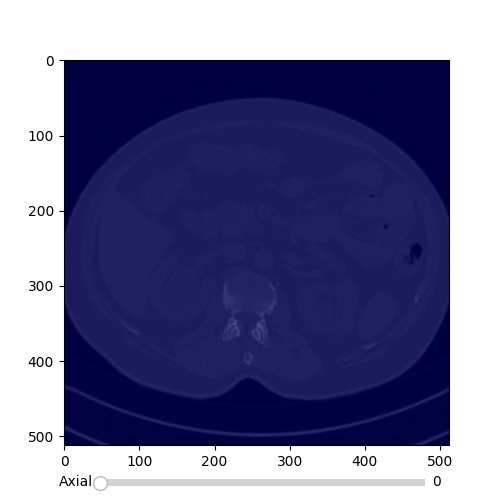

In [21]:
%matplotlib widget
ColorImageSliceViewer3D(example_overlap)